In [109]:
# Exmaple from SHAP
# This codee has the purpose to figure out why my first implementation of svm was not working
# https://github.com/slundberg/shap/blob/master/docs/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from helper import read_imdb_split,download_data
np.random.seed(1337)
shap.initjs()

In [110]:
download_data()

'Already downloaded and extracted.'

In [111]:
texts, labels = read_imdb_split('../data/aclImdb/train')

In [112]:
data = pd.DataFrame({'text':texts, 'labels':labels})

len(data)

25000

In [113]:
stopwords_set = set(stopwords.words('english'))

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

word_Lemmatized = WordNetLemmatizer()

def preprocessing(text):
    # Using list comprehension to generate the final words
    final_words = [
        word_Lemmatized.lemmatize(word, tag_map[tag[0]])
        for word, tag in pos_tag(text)
        if word.isalpha() and word not in stopwords_set
    ]
    return ' '.join(final_words)

In [114]:
# Step - a : Remove blank rows if any.
data['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
data['text'] = [entry.lower() for entry in data['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
data['text']= [word_tokenize(entry) for entry in data['text']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.

data['text_final'] = data['text'].apply(preprocessing)

In [115]:
data.head()

,text,labels,text_final
0,"[great, little, thriller, ., i, was, expecting...",1,great little thriller expect type silly horror...
1,"[nothing, could, have, saved, this, movie, ,, ...",0,nothing could save movie even br br ten year a...
2,"[this, was, a, good, movie, ., it, was, n't, y...",1,good movie typical war flick something bit dif...
3,"[from, the, pen, of, richard, condon, (, the, ...",0,pen richard condon manchurian candidate come m...
4,"[i, suppose, that, today, this, film, has, rel...",0,suppose today film relevance early sofia loren...


In [116]:
corpus = data['text_final'].tolist()
labels = data['labels'].tolist()

corpus_train, corpus_test, y_train, y_test = model_selection.train_test_split(corpus,labels,test_size=0.2)

In [117]:
print(corpus_train[:1])

['ahh dull show pilot slam together make equally dull movie example would rid death hysterically cheesy lot strand space confuse uninteresting san francisco international horribly dull unbelievably confuse turgid bit quinn martin glamor br br shot hawaii although would know outside shot apparently failed pilot lame spy show real problem like character include drab main character diamond head seem half asleep entire movie bos mary really weird delivery line shellac white hair well tan look like stucco diamnd head agent hell ca even remember name skinny wooden woman flat way speaking sexy interesting singing sidekick zulu ca remember character name bad small dos interesting person whole production ian mcshane suck bad guy still prove acting chop alothugh job use disguise laughable absolutely idea try steal lab cause dress south american dictator cum american general care plot simply interesting enough hold attention even ten minute time let alone hour half go call one hawaii five']


In [118]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

In [119]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [120]:
print(X_train[0])

  (0, 4301)	0.07197075847897856
  (0, 7937)	0.02490936362128133
  (0, 1523)	0.054622527653664314
  (0, 4795)	0.032188174267653025
  (0, 5456)	0.058524392963937515
  (0, 312)	0.06824686487478036
  (0, 6558)	0.053601280109782025
  (0, 11428)	0.030536050823508194
  (0, 7279)	0.050644553850686384
  (0, 11257)	0.07183415082975553
  (0, 690)	0.06955759618717597
  (0, 5366)	0.06331170472674486
  (0, 3742)	0.050263873299617144
  (0, 10250)	0.05878472769554188
  (0, 8525)	0.04129553460622188
  (0, 1605)	0.059705851805882726
  (0, 4673)	0.0727007653249064
  (0, 2628)	0.13084927007315048
  (0, 3067)	0.11680083964736275
  (0, 359)	0.11709576732617323
  (0, 10531)	0.08399445389007175
  (0, 3388)	0.07769255098377463
  (0, 1696)	0.06955759618717597
  (0, 6384)	0.10345246703368809
  (0, 10737)	0.07224756147894532
  :	:
  (0, 11753)	0.10053245216237966
  (0, 5434)	0.0916960339604338
  (0, 5924)	0.0899802722762176
  (0, 4480)	0.10365416056791046
  (0, 9751)	0.09709979422979398
  (0, 11880)	0.09319551922

In [121]:
# Evaluate our classifier's performance
sklearn.metrics.accuracy_score(model.predict(X_test), y_test)

0.859

In [205]:
# Initialize the explainer
explainer = shap.Explainer(model, X_train, feature_names=vectorizer.get_feature_names_out())
# Apply it to the test data
shap_values = explainer(X_test)

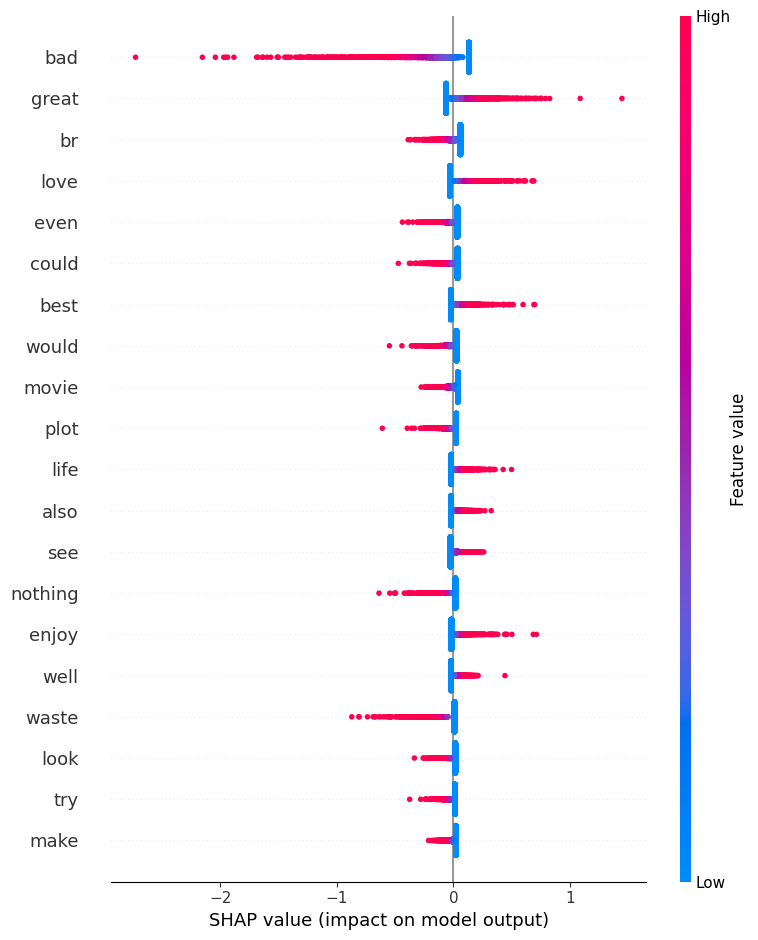

In [207]:
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array)

In [124]:
# find index of word FUN

feature_names = vectorizer.get_feature_names_out().tolist()

def feature_index(feature):
    return feature_names.index(feature)


## Prediction Decomposition

NExt, lets look at the explanation for a single review. Here we, decompose a prediciton with the following equation.
`sum(SHAP values for all features) = pred_for_review - pred_for_baseline_values`

The SHAP values of all features sum up to explain why the prediction was different from the baseline.

In [222]:
index = 7
print("Positive" if y_test[index] else "Negative", "Review:")
print(corpus_test[index])


shap.plots.force(
    explainer.expected_value, 
    shap_values.values[index],
    feature_names=feature_names,
)


Positive Review:
first von trier movie ever see break wave sure nice movie definitely stand shadow europa europa tell story young want experience germany second world war take job uncle arrange purser luxues train job travel almost totally destroyed germany meet killing traitor hunt former nazi party member society suffer corruption uncle narrow conciousness focus job also purser train coincidence main character get involve bombing terrorism group call put pressure help place bomb train atmosphere astound viewer take scene scene man attempt put viewer hypnosis count wake new scene think see lot europe


We predicted 0.93, whereas the base_value is -0.098 Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. 
In this example, the biggest impacts come from the features "bad" and "Job" which are strongly positive.

Nexts lets identify the features that contribute to the positive and negative classification of a document

In [209]:
def top_words(index=0, return_type="positive", num_words=10):
  print(corpus_test[index])
  vals = shap_values[index,:].values
  positive_sentiment_weight = defaultdict(float)
  negative_sentiment_weight = defaultdict(float)
  feats = vectorizer.get_feature_names_out()

  for feat_i, val_i in zip(feats, vals):
    if val_i > 0:
      positive_sentiment_weight[feat_i] += val_i
    elif val_i < 0:
      negative_sentiment_weight[feat_i] += val_i

  if return_type == "positive":
    return sorted(positive_sentiment_weight.items(), key=lambda x: x[1], reverse=True)[:num_words]
  elif return_type == "negative":
    return sorted(negative_sentiment_weight.items(),  key=lambda x: x[1], reverse=True)[:num_words]

In [210]:
top_words(index=index, return_type="positive", num_words=10)

first von trier movie ever see break wave sure nice movie definitely stand shadow europa europa tell story young want experience germany second world war take job uncle arrange purser luxues train job travel almost totally destroyed germany meet killing traitor hunt former nazi party member society suffer corruption uncle narrow conciousness focus job also purser train coincidence main character get involve bombing terrorism group call put pressure help place bomb train atmosphere astound viewer take scene scene man attempt put viewer hypnosis count wake new scene think see lot europe


[('job', 0.1790106619083695),
 ('bad', 0.13316118416241912),
 ('definitely', 0.07057777235751303),
 ('br', 0.05937360018152939),
 ('world', 0.05488001934026195),
 ('atmosphere', 0.04886334627273071),
 ('see', 0.045118453831769566),
 ('also', 0.04382790929885371),
 ('war', 0.041410452682683896),
 ('young', 0.036549778983254004)]

In [211]:
top_words(index=index, return_type="negative", num_words=10)

first von trier movie ever see break wave sure nice movie definitely stand shadow europa europa tell story young want experience germany second world war take job uncle arrange purser luxues train job travel almost totally destroyed germany meet killing traitor hunt former nazi party member society suffer corruption uncle narrow conciousness focus job also purser train coincidence main character get involve bombing terrorism group call put pressure help place bomb train atmosphere astound viewer take scene scene man attempt put viewer hypnosis count wake new scene think see lot europe


[('cheesiness', -1.0515917415394597e-07),
 ('jam', -1.221760950985898e-07),
 ('guessing', -3.6454095297321065e-07),
 ('tool', -4.961417592499117e-07),
 ('unveil', -5.192349269059291e-07),
 ('goodfellas', -5.508726177312028e-07),
 ('pornography', -5.644339627141332e-07),
 ('incidentally', -5.745836680435377e-07),
 ('yield', -6.01332155488795e-07),
 ('description', -6.110985627323491e-07)]

Comparing sparse matrices using == is inefficient, try using != instead.


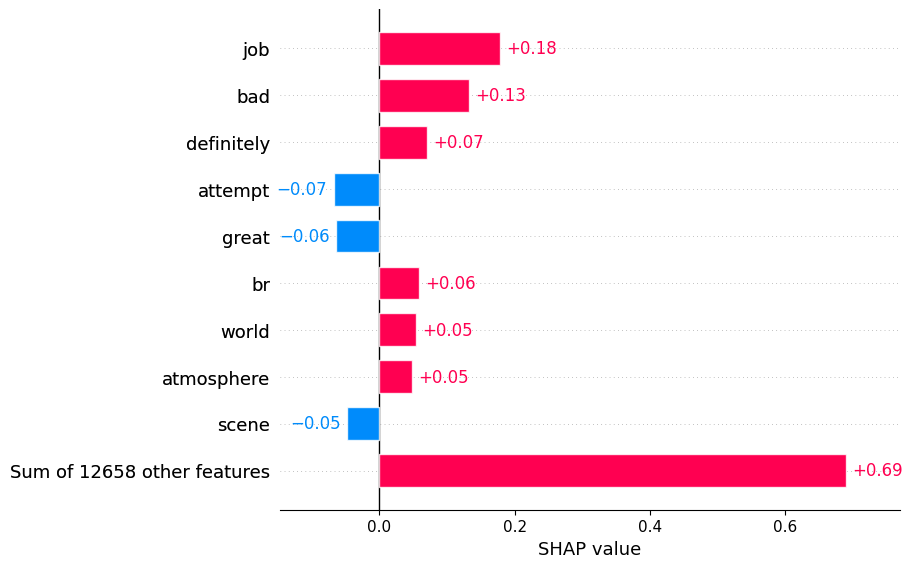

In [239]:
shap.plots.bar(shap_values[index])

# Select another review and explain the prediction

In [213]:
shap.initjs()
index = 10
print("Positive" if y_test[index] else "Negative", "Review:")
print(corpus_test[index])
shap.plots.force(
    explainer.expected_value, 
    shap_values.values[index],
    feature_names=feature_names,
)

Negative Review:
previous comment encourage check show tcm severe disappointment lupe valdez great get enough screen time frank morgan eugene palette play familiar promising character script leave br br movie revolve around ego lee tracy character best physically verbally abusive jerk reaction public poorly unbelievable make shenanigan seem like contrivance bad writer strain credulity lupe velez character could fall br br stinging mention another review must dependent observer since even notice attempt make


In [214]:
top_words(index=index, return_type="positive", num_words=10)

previous comment encourage check show tcm severe disappointment lupe valdez great get enough screen time frank morgan eugene palette play familiar promising character script leave br br movie revolve around ego lee tracy character best physically verbally abusive jerk reaction public poorly unbelievable make shenanigan seem like contrivance bad writer strain credulity lupe velez character could fall br br stinging mention another review must dependent observer since even notice attempt make


[('great', 0.12925452479187233),
 ('best', 0.10445325745631644),
 ('show', 0.03304841612944112),
 ('frank', 0.030392465776954168),
 ('play', 0.028723913205836685),
 ('familiar', 0.028300203972272987),
 ('would', 0.025443503146580546),
 ('plot', 0.02306705120746185),
 ('morgan', 0.020581253081083467),
 ('check', 0.018866898823525068)]

In [218]:
top_words(index=index, return_type="negative", num_words=10)


discovery cinema jan svankmajer open eye whole tradition czech animation jirí trnka pioneer ruka one fine animated movie ever br br potter wake water plant go make pot come huge hand crash pot demand potter make statue cast hand soon return imprisons bird cage force sculpt stone hand set faint exhaustion eventually complete br br marvellous sequence metacinema potter use candle burn visible puppet string keep thrall escape back home shut accidentally kill beloved plant fall br br movie hide fact pure animation unlike modern movie strive realistic hand instance clearly someone hand glove everything else clay string visible part narrative make precursor movie string atmosphere eerie hand go little potter manage instill dread many horror movie br br movie obvious avoid totally manipulative simplicity fable artistic freedom tyranny ca help win heart mind anyone hold freedom natural right


[('cheesiness', -1.0515917415394597e-07),
 ('jam', -1.221760950985898e-07),
 ('guessing', -3.6454095297321065e-07),
 ('tool', -4.961417592499117e-07),
 ('unveil', -5.192349269059291e-07),
 ('goodfellas', -5.508726177312028e-07),
 ('pornography', -5.644339627141332e-07),
 ('incidentally', -5.745836680435377e-07),
 ('yield', -6.01332155488795e-07),
 ('description', -6.110985627323491e-07)]

Comparing sparse matrices using == is inefficient, try using != instead.


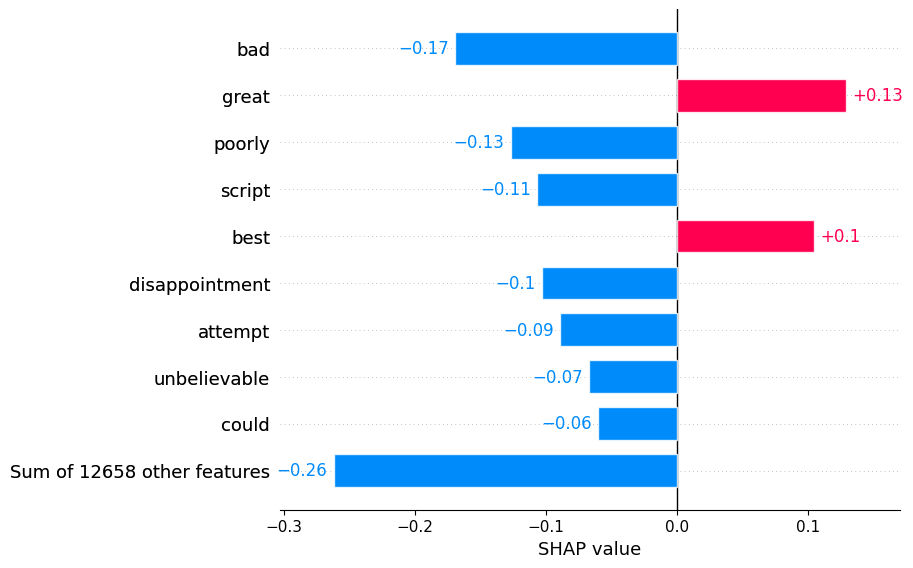

In [220]:
shap.plots.bar(shap_values[index])